## Final Exam: Hands-On Portion


**Instructions**
This should take 1 - 2 hours of time. Do your best! We'll be grading not based accuracy, but on comprehension of the problem, the methods noted, and your approach. Good luck! 

### **The Challenge**

The executive team is interested in a user class called **"Adopted Users"** for its cloud project collaboration platform. 

What's an "Adopted User"?
- The team has defined this as a user who **logs in at least once a day across 3 days in seven day period**. 

- This means, Chris is a super user if he logs in on Monday, Wednesday and Friday. He's also a super user if he logs in Tuesday, Friday, then the following Monday. Thus the problem deals with "rolling" periods. 

**A. Use time-series data in the table "user_engagement.csv" to tag these users**.

After identifying these users, the team would like to find out: 

**B. "What factors drives users to become 'Adopted Users'"? **

This means a mixture of exploratory data analysis, feature engineer, model, crossvalidation and parameter tuning, and finally running feature importance. Feel free to use your creativity and explore and think through other potential solutions.



## Read Essentials

In [324]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

raw_users = pd.read_csv('./users.csv', encoding='latin-1')
raw_user_engagement = pd.read_csv('./user_engagement.csv')

**Data Dictionary:**

A. user_engagement.csv
- time_stamp: mm/dd/yyy hh:mm:ss
- user_id
- visited: 1, indicating that they visited 

B. users.csv
- name:  the  user's  name
- object_id: the  user's  id
- email: email address
-  creation_source: How was account created?
    - personal_projects: invited to join another user's personal workspace
    - guest_invite: invited to an organization as a guest (limited permissions)
    - org_invite: invited to an organization (as a full member)
    - signup: signed up via the website
    - signup_google_auth: signed up using google authentication (using a google email account for their login id)
    
- creation_time:  when  they  created  their  account
- last_session_creation_time:   unix  timestamp  of  last  login
- opted_in_to_mailing_list:  whether  they  have  opted  into  receiving
marketing  emails
- enabled_for_marketing_drip:  whether  they  are  on  the  regular
marketing  email  drip
- org_id:   the  organization  (group  of  users)  they  belong  to
- invited_by_user_id:   which  user  invited  them  to  join  (if  applicable).


## 1. Explore 
1. User Desribe and Head to explore your two datasets
2. create a few bar plots to explore your data
- [Some ideas](https://machinelearningmastery.com/quick-and-dirty-data-analysis-with-pandas/)
3. How many unique user_ids are there in each table? in both?

List out some cleansing steps and note things you might have to have you do in order to get your data set into a feature frame and a target frame.

Helpful functions: 
- is.in, groupby, plot.bar()

In [2]:
raw_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,4/22/2014 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,11/15/2013 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,3/19/2013 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,5/21/2013 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,1/17/2013 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
raw_user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [190]:
# PART 1
# determine super user (someone who logs in at least 3 different days in 7 day period)
# *** as long as the user has at least once achieved super user status, they're permanently a super user
# *** meaning that they don't have to continuously log in 3 different days in 7 day period for the rest of the time

# PART 2
# identify features of a super user

# there are 12000 users
raw_user_engagement.user_id.describe()

# turn time stamps into usable data
x = pd.to_datetime(raw_user_engagement.time_stamp)

0   2014-04-22 03:53:30
1   2013-11-15 03:45:04
2   2013-11-29 03:45:04
3   2013-12-09 03:45:04
4   2013-12-25 03:45:04
Name: time_stamp, dtype: datetime64[ns]

## 2.  Create your Target Variable
1. You want to use a combination of steps to create a rolling 7 day period window. This rolling window of 7 days should count the number of log-ins. 
2. (optional) Execute any additional Exploratory Data analysis (EDA) you wish:

        Exploratory Data Analysis (EDA) is used on the one hand to answer questions, test business assumptions, generate hypotheses for further analysis. On the other hand, you can also use it to prepare the data for modeling. The thing that these two probably have in common is a good knowledge of your data to either get the answers that you need or to develop an intuition for interpreting the results of future modeling.


A few helpful methods in pandas
- [to_period](https://stackoverflow.com/questions/23840797/convert-a-column-of-timestamps-into-periods-in-pandas)
- [groupby](https://www.google.com/search?q=groupby&oq=groupby&aqs=chrome..69i57j0l2j69i60l3.1487j1j4&sourceid=chrome&ie=UTF-8)
- [resample](http://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.DataFrame.resample.html)
- [rolling](http://pandas.pydata.org/pandas-docs/stable/computation.html#window-functions)

Inputs:
- user_engagement

Output: 
- Call your target dataframe "target"


In [154]:
user_engagement = raw_user_engagement
user_engagement['time_stamp'] = x

u_dict = {}

# shove each user log history into dictionary, only if they have at least 3 log ins
for u in user_engagement.user_id:
    if len(user_engagement[user_engagement.user_id==u]) > 2:
        u_dict[u] = user_engagement[user_engagement.user_id==u]
    

In [289]:
# for each user history, fill each recorded time with 1, and fill 0 for the rest of the days
# get users for sum > 3

super_users = []
for k in u_dict.keys():
    temp = pd.DataFrame(np.ones([len(u_dict[k]), 1]))
    temp.columns = ['visited']
    # set the index with the timestamp
    temp = temp.set_index(u_dict[k].time_stamp.dt.date)
    temp.index = pd.to_datetime(temp.index)
    temp = temp.resample('1D', how=lambda x: x.mean() if len(x) > 0 else 0)
    # if user logged in for 3 days in 7 days, then sum should be at least 1
    num_super_visit = (temp.rolling(window=7, min_periods=0).sum() > 2).sum()[0]
    if num_super_visit > 0:
        super_users.append(k)

/Users/leey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  # This is added back by InteractiveShellApp.init_path()


In [297]:
print(len(super_users))
print(len(u_dict.keys()))
print(super_users[:10])

1594
2007
[2, 10, 20, 33, 42, 43, 50, 53, 63, 69]


In [295]:
target = raw_users[raw_users.object_id.isin(super_users)]

In [301]:
print(target.shape)
target.head()

(1594, 10)


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
1,2,11/15/2013 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
9,10,1/16/2013 22:08,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0
19,20,3/6/2014 11:46,Helms Mikayla,lqyvjilf@uhzdq.com,SIGNUP,1.401364e+09,0,0,58,NaN
32,33,3/11/2014 6:29,Araujo José,JoseMartinsAraujo@cuvox.de,GUEST_INVITE,1.401518e+09,0,0,401,79.0
41,42,11/11/2012 19:05,Pinto Giovanna,GiovannaCunhaPinto@cuvox.de,SIGNUP,1.401045e+09,1,0,235,NaN


## 3. Data Cleanse  + Feature Engineering:
- Are there any steps you need to take to cleanse the data some more?
- Do you need to apply any masks?
- Do you need to take care of missing data? 
- Anything you need to drop? Things that don't make sense to include as a feature? .drop(['col1','col2'], axis = 1)
- Can you think of any features to create?
- do you need to one hot encode? pd.get_dummies or OneHotEncode from sklearn

Other useful functions:
- pd.concat([df1,df2], axis = 1) -- this will bind two dataframes column wise

Outputs: 
- y, your target 
- X, a dataframe for features

In [325]:
users = raw_users 

# target has the super users
# I have to re-encode user id to true/false (super user/not super user)
users.loc[~raw_users.object_id.isin(super_users),'object_id']=0
users.loc[raw_users.object_id.isin(super_users), 'object_id']=1

# select features to detect super user id (object_id)
X = users[['opted_in_to_mailing_list','enabled_for_marketing_drip','org_id']]
y = users.object_id

In [326]:
y.describe()

count    12000.000000
mean         0.132833
std          0.339409
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: object_id, dtype: float64

### 4.Train Test Split
- use "train_test_split" from sklearn.model_selection.
- use random_state = 100 
- test_size = .15

In [344]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .15, random_state = 100)
X_train.shape,y_train.shape, X_test.shape, y_test.shape,

((10200, 3), (10200,), (1800, 3), (1800,))

### 5. Modeling
- Choose 1 or 2 classifier (or regressors, depending on what your target variable is)
- use some cross validation and parameter optimization techiniques[hints here](https://github.com/hackoregon/civicu-machine-learning/blob/master/lessons/13-Hyperparameter-Optimization/Class%2013%20-%20Part%201%2C%20Hyper%20Parameter%20Tuning.ipynb):
    - cross validaiton
    - manaul search 
    - random search or gridsearch
- choose a scoring method (depends on classificaton or regression task)



Hint:
- If your gridsearch doesn't work, try X_train.values y_train.values

In [336]:
# use randomforest
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_jobs=-1, n_estimators = 10)
clf.fit(X_train,y_train)
clf.score(X_test, y_test)

0.85611111111111116

In [337]:
def explore_grid (param_grid):
    clf = RandomForestClassifier(n_jobs=-1, n_estimators = 10)
    grid_explore = GridSearchCV(
        clf,
        param_grid,
        cv=4,
        scoring='accuracy')
    grid_explore.fit(X_train, y_train)
    return pd.DataFrame(grid_explore.grid_scores_)[['parameters','mean_validation_score']]

/Users/leey/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


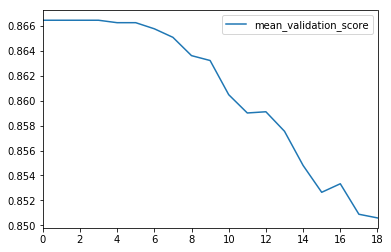

In [340]:
max_depth_explore = explore_grid([{"max_depth": np.arange(1,20)}])
max_depth_explore.plot()

/Users/leey/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


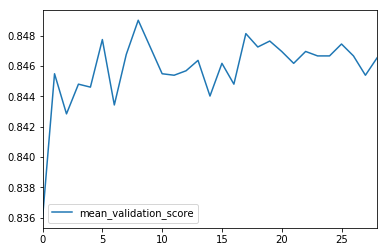

In [342]:
max_depth_explore = explore_grid([{"n_estimators": np.arange(1,30)}])
max_depth_explore.plot()

In [345]:

param_dist = {"max_depth": np.arange(1,6),
              "n_estimators": np.arange(5,10)
             }

clf = RandomForestClassifier(n_jobs=-1)

# run randomized search
n_iter_search = 7
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   cv=4,
                                   n_iter=n_iter_search)
random_search.fit(X, y)

RandomizedSearchCV(cv=4, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=7, n_jobs=1,
          param_distributions={'max_depth': array([1, 2, 3, 4, 5]), 'n_estimators': array([5, 6, 7, 8, 9])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [347]:
random_search.best_estimator_.score(X_test,y_test)

0.87111111111111106

In [348]:
random_search.best_estimator_.feature_importances_

array([ 0.00958585,  0.02025067,  0.97016348])

### 6. Test Performance on holdout data  (x_test, y_test)
1. Which performance metric would you use for this?
2. Bring up confusion matrix from confusion matrix and classification report

In [71]:
from sklearn.metrics import classification_report, confusion_matrix


#y_pred_in =  # your predictions
#y_test_in =  # your true ys
#print(classification_report(y_pred=y_pred_in, y_true=y_test_in))
#print(confusion_matrix(y_pred=y_pred_in, y_true=y_test_in))

### 7. Feature Importance
- Goal: Create a table with two columns: Variable and Importance. Sort by Importance. 
- Use either [permutation Feature Importance (may take a while)](https://github.com/hackoregon/civicu-machine-learning/blob/master/lessons/13-Hyperparameter-Optimization/Class%2013%20-%20Part%202%2C%20Permutation%20Feature%20Importance.ipynb) or [RandomForest's Feature Importance method](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [70]:
importance = pd.DataFrame(
    {'Variable': [], 
     'Importance':[]},
    columns = ["Variable", "Importance"])\
    .sort_values('Importance', ascending = False)
importance

,Variable,Importance


### 8. Story Telling
- What are your next steps now? 
- What do you want to tell leadership?
- How confident are you with this information?
- Are there additional steps or data sets that you'd like to perform?

Write 1 to 2 paragraphs or a a few bullet points discussing the above.